In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import scanpy.api as sc
import pandas as pd
import h5py
import os
import time
import itertools
from sklearn.decomposition import PCA

## Network
from community import community_louvain
import networkx as nx
import matplotlib.pyplot as plt

from util import *
import data_loader as dl
import scdd as sd
import csv

import dist_deconv_1d as dd1d

%matplotlib inline
%load_ext autoreload
%autoreload 2

/home/martin/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
## 
output_folder = './figures/figure_gene_network_VN/'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
# data = dl.load_10x_1_3mil_subsample(opt=1)
# sc.pp.subsample(data,fraction=0.002,copy=False)
# data = dl.load_10x_4k()
# gene_list_raw = np.array(data.var_names)
# sc.pp.filter_genes(data,min_counts=0.05*data.shape[0])
# Nc,G,Nr,Nr_bar = sd.get_info(data)
# gene_list = np.array(data.var_names)

In [3]:
## marker gene
marker_gene_dic = {} 
marker_gene_dic['T-cells']= ['IL7R','CD3G','CD3E','CD3D','LCK']
marker_gene_dic['NK-cells']= ['NKG7','PRF1','KLRD1','GZMA','HOPX','CST7']
marker_gene_dic['B-cells']= ['CD79A','BANK1','IGHD','LINC00926','MS4A1']
marker_gene_dic['myeloid']= ['S100A8','S100A9']
marker_gene_dic['Innate Immunity']= ['MNDA','FGL2','CLEC7A','CD6S','IFI30']
# marker_gene_dic['HSC']= ['CD34','GATA2','PRSS57','SMIM24','CYTL1']
marker_gene_dic['Megakaryocytes']= ['PF4','PPBP']
marker_gene_dic['house keeping'] = ['RPL18', 'RPL13', 'RPL10A']
marker_gene_dic['mt'] = ['MT-ND4', 'MT-ATP6', 'MT-ND1', 'MT-ND3', 'MT-CO3', 'MT-CO2',
        'MT-CO1', 'MT-CYB', 'MT-ND2', 'MT-ND5', 'MT-ND4L']

# print('## Not in gene_list_raw')
# for key in marker_gene_dic:
#     for gene in marker_gene_dic[key]:
#         if gene not in gene_list_raw:
#             print(key,gene)

# print('')
# print('## Not in gene_list')
# for key in marker_gene_dic:
#     for gene in marker_gene_dic[key]:
#         if gene not in gene_list:
#             print(key,gene)

# Some functions

In [98]:
def mod_analysis(adj,gene_list=None,G_name='',min_node=5):
    
    if type(adj) == nx.classes.graph.Graph:
        G = adj
    else:
        G = nx.from_numpy_matrix(adj)
        
    if gene_list is None:
        gene_list = np.arange(G.number_of_nodes())
    print('Graph %s, n_node=%d, n_edge=%d'%(G_name,G.number_of_nodes(),G.number_of_edges()))
    partition = community_louvain.best_partition(G)
    mod_dic = partition_to_label(partition,min_node=min_node)
    
    mod_dic_ = mod_dic.copy()
    #print(mod_dic_)
    ## sort the nodes in each module by degree
    for key in mod_dic:
        H = G.subgraph(mod_dic[key])
        node_list = []
        degree_list = []
        for H_node,H_deg in H.degree:
            node_list.append(H_node)
            degree_list.append(H_deg)
        degree_list = np.array(degree_list)
        new_node_list = []
        for i_node in np.argsort(degree_list)[::-1]:
            new_node_list.append(node_list[i_node])
        mod_dic[key] = new_node_list 
    #return mod_dic
    for key in mod_dic.keys():
        print('Module %d, size=%d'%(int(key),len(mod_dic[key])))
        mod_dic[key] = gene_list[mod_dic[key]]
    return mod_dic

def check_marker_genes(mod_dic,marker_gene_dic):
    for key in marker_gene_dic:
        print('## Module %s'%key)
        for gene in marker_gene_dic[key]:
             for key_ in mod_dic.keys():
                if gene in mod_dic[key_]:
                    print('   %s: module %d'%(gene,key_))
        print(' ')
        
def partition_to_label(partition,min_node=5):
    mod_dic = {}
    for key in partition.keys():
        val = partition[key]
        if val not in mod_dic:
            mod_dic[val] = [key]
        else:
            mod_dic[val].append(key)
    key_list = list(mod_dic.keys())
    size_list = np.zeros([len(key_list)],dtype=int)
    
    for i_key,key in enumerate(key_list): 
        size_list[i_key] = len(mod_dic[key])
        
    mod_dic_new = {}
    for rank,i_key in enumerate(np.argsort(size_list)[::-1]):
        key = key_list[i_key]
        if size_list[i_key]>min_node:
            mod_dic_new[rank] = mod_dic[key] 
        
    return mod_dic_new

def draw_G(G,partition):
    #drawing
    size = float(len(set(partition.values())))
    pos = nx.spring_layout(G)
    count = 0.
    for com in set(partition.values()) :
        count = count + 1.
        list_nodes = [nodes for nodes in partition.keys()
                                    if partition[nodes] == com]
        nx.draw_networkx_nodes(G, pos, list_nodes, node_size = 20,
                                    node_color = str(count / size))


    nx.draw_networkx_edges(G,pos, alpha=0.5)
    plt.show()

def get_index(temp_list,gene_list):
    temp_index = []
    for i in temp_list:
        temp_index.append(np.where(gene_list==i)[0][0])
    return temp_index

def shrink_PC(cov_,shrink_param=0.1):
    ## clip the variance estimation to be 0: ???
    diag_cov_ = np.diag(cov_)
    index_bad = (diag_cov_<=1e-1)
    np.fill_diagonal(cov_,diag_cov_.clip(min=1e-12))
        
    ## Pearson correlation
    std_ = np.sqrt(diag_cov_) + shrink_param    
    #std_dd = np.sqrt(diag_cov_dd)
    std_ = std_.reshape([cov_.shape[0],1])
    PC_ = cov_/(std_.dot(std_.T))
    PC_ = PC_.clip(min=-1,max=1)
    np.fill_diagonal(PC_,1)
    
    ## for the bad index, remove the estimation: ???
    PC_[:,index_bad] = 0
    PC_[index_bad,:] = 0
    return PC_

def write_NET_csv(knn,gnames,outfile):
    adj_csv = []
    adj_csv= [['']+[i for i in gnames]]
    for i in range(knn.shape[0]):
        adj_csv+= [ [gnames[i]]+[j for j in knn[:,i]]  ]

    myFile = open(outfile, 'w')
    with myFile:
        writer = csv.writer(myFile,delimiter=';')
        writer.writerows(adj_csv)
        
def marker_gene_heatmap(marker_gene_dic,gene_list,val,title=''):
    marker_gene_list = []
    marker_gene_group = []
    for i_key,key in enumerate(marker_gene_dic):
        for gene in marker_gene_dic[key]:
            if gene in gene_list:
                marker_gene_list.append(gene)
                marker_gene_group.append(key+':'+gene)
    n_gene = len(marker_gene_list)
    idx_ = get_index(marker_gene_list,gene_list)
    val = val[idx_,:][:,idx_]
    plt.figure(figsize=[12,12])
    plt.imshow(val,vmin=-1,vmax=1)

    plt.colorbar(fraction=0.046, pad=0.04)
    
    plt.xticks(np.arange(n_gene),marker_gene_list,rotation=45)
    plt.yticks(np.arange(n_gene),marker_gene_list)
    for i in range(n_gene):
        for j in range(n_gene):
            text = plt.text(j,i,'%0.2f'%val[i,j],
                           ha="center", va="center", color="w")
    plt.tight_layout()
    plt.title(title,fontsize=12)
    plt.show()
    
    
def intersection(lst1, lst2):
    lst3 = [value for value in lst1 if value in lst2]
    return lst3

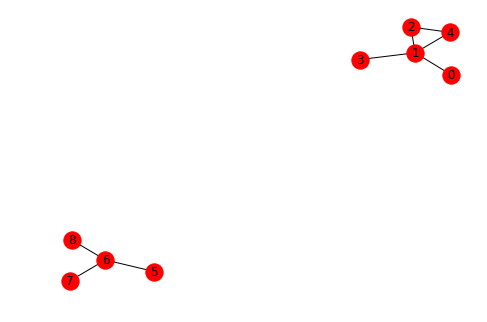

Graph , n_node=9, n_edge=8
Module 0, size=5
Module 1, size=4


{0: array([1, 4, 2, 3, 0]), 1: array([6, 7, 5, 8])}

In [5]:
## a toy test example
G = nx.Graph()
G.add_nodes_from([0,1,2,3,4,5,6,7,8])
G.add_edges_from([(1,0),(1,2),(1,3),(2,4),(1,4),(5,6),(6,7),(6,8)])
plt.figure()
nx.draw(G,with_labels=True)
plt.show()
mod_analysis(G,min_node=0)

# Analysis

In [273]:
## load the data 
data = dl.load_10x_4k()
data.var_names_make_unique()
sc.pp.filter_genes(data,min_counts=0.00001*data.shape[0])
Nc,G,Nr,Nr_bar = sd.get_info(data)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
## Nc=4340, G=19773, Nr=4349.04, Nr_bar=0.22


In [274]:
# # ## subsample the data 

sub=1

# subc=1

# Nr_new = Nr/sub
# Nc_new = int(Nc*subc)
# data = sd.subsample_anndata(data,Nr_new,Nc_new)

In [275]:
## filter and calculate PC
size_factor = sd.dd_size_factor(data,verbose=False)
M_ml,M_dd = sd.dd_1d_moment(data,size_factor=size_factor)
var_dd = sd.M_to_var(M_dd)
gene_list = np.array(data.var_names)[var_dd>0.1/(sub**2)]
data = data[:,list(gene_list)]

#time start: 0.0s
n_cell=4340, n_gene=19773
#total: 0.27s


In [276]:
data

View of AnnData object with n_obs × n_vars = 4340 × 791 
    var: 'n_counts'

In [277]:
# calculate PC
mean_ml,cov_ml,PC_ml  = sd.ml_covariance(data,size_factor=size_factor)
mean_dd,cov_dd,PC_dd  = sd.dd_covariance(data,size_factor=size_factor,PC_prune=False)

#time start: 0.0s
n_cell=4340, n_gene=791, Nr=3224.3
#total: 3.11s
#time start: 0.0s
n_cell=4340, n_gene=791, Nr=3224.3
#total: 3.19s


In [149]:
# ## network analysis (play with this to access how good the netwrok is)

# marker_gene_dic = {} 
# marker_gene_dic['T-cells']= ['IL7R','CD3G','CD3E','CD3D','LCK']
# marker_gene_dic['NK-cells']= ['NKG7','PRF1','KLRD1','GZMA','HOPX','CST7']
# marker_gene_dic['B-cells']= ['CD79A','BANK1','IGHD','LINC00926','MS4A1']
# marker_gene_dic['myeloid']= ['S100A8','S100A9']
# marker_gene_dic['Innate Immunity']= ['MNDA','FGL2','CLEC7A','CD6S','IFI30']
# marker_gene_dic['Megakaryocytes']= ['PF4','PPBP']
# marker_gene_dic['house keeping'] = ['RPL18', 'RPL13', 'RPL10A']
# marker_gene_dic['mt'] = ['MT-ND4', 'MT-ATP6', 'MT-ND1', 'MT-ND3', 'MT-CO3', 'MT-CO2',
#         'MT-CO1', 'MT-CYB', 'MT-ND2', 'MT-ND5', 'MT-ND4L']

# ## PC_dd
# adj_ = PC_dd>0.8
# np.fill_diagonal(adj_,0)
# mod_ = mod_analysis(adj_,gene_list,G_name='PC_dd')
# print('')
# print('## check marker genes')
# check_marker_genes(mod_,marker_gene_dic)

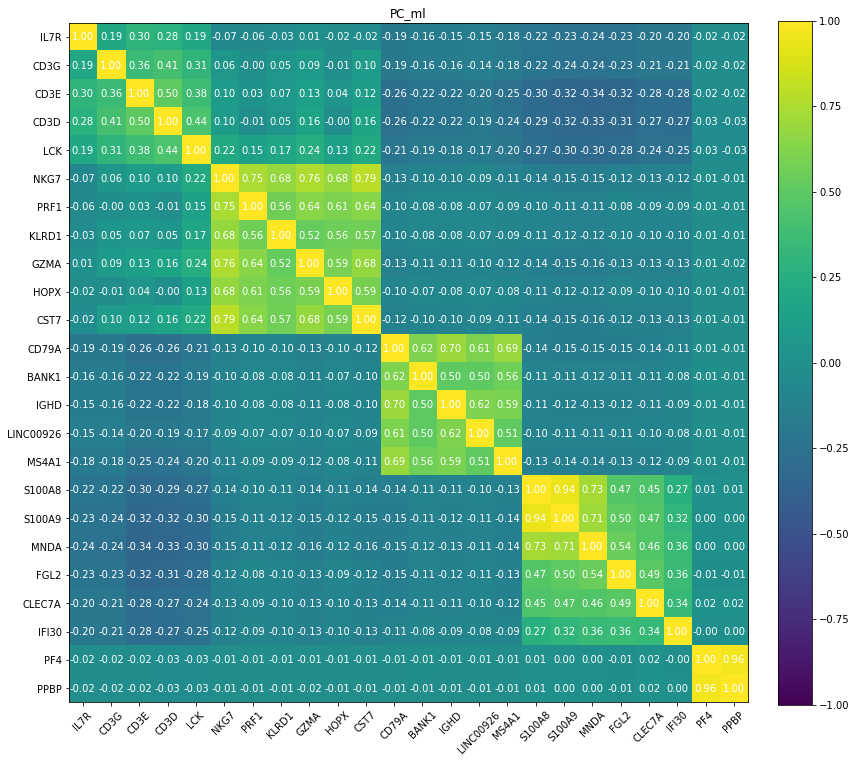

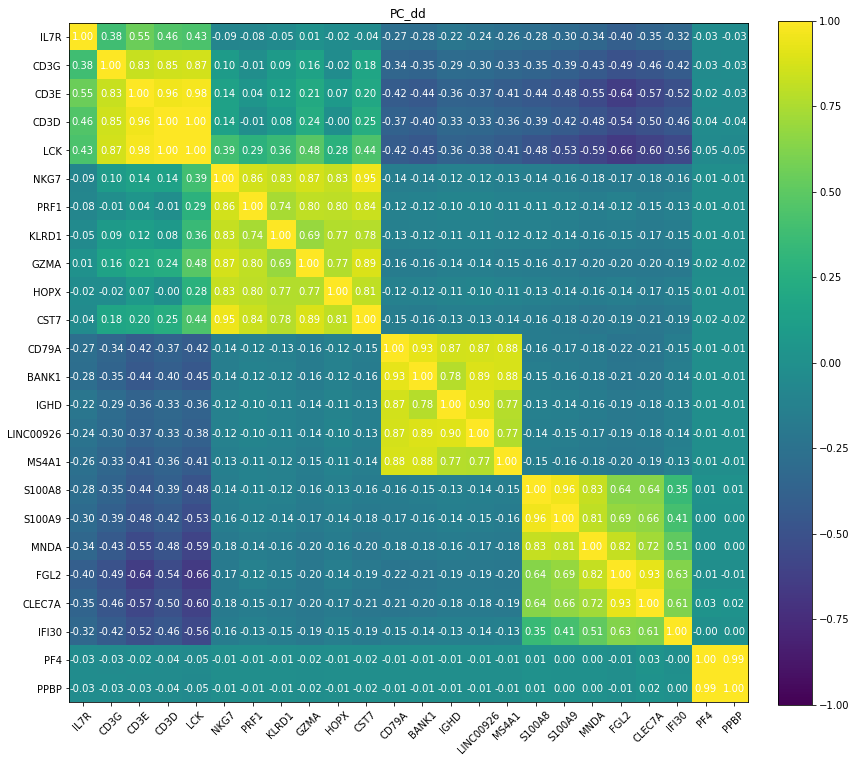

In [150]:
## visualization 
## marker gene
marker_gene_dic = {} 
marker_gene_dic['T-cells']= ['IL7R','CD3G','CD3E','CD3D','LCK']
marker_gene_dic['NK-cells']= ['NKG7','PRF1','KLRD1','GZMA','HOPX','CST7']
marker_gene_dic['B-cells']= ['CD79A','BANK1','IGHD','LINC00926','MS4A1']
marker_gene_dic['myeloid']= ['S100A8','S100A9']
marker_gene_dic['Innate Immunity']= ['MNDA','FGL2','CLEC7A','CD6S','IFI30']
marker_gene_dic['Megakaryocytes']= ['PF4','PPBP']
# marker_gene_dic['house keeping'] = ['RPL18', 'RPL13', 'RPL10A']
# marker_gene_dic['mt'] = ['MT-ND4', 'MT-ATP6', 'MT-ND1', 'MT-ND3', 'MT-CO3', 'MT-CO2',
#         'MT-CO1', 'MT-CYB', 'MT-ND2', 'MT-ND5', 'MT-ND4L']

marker_gene_heatmap(marker_gene_dic,gene_list,PC_ml,title='PC_ml')
marker_gene_heatmap(marker_gene_dic,gene_list,PC_dd,title='PC_dd')

In [287]:
import seaborn as sns

In [288]:
markgenes_=[str(i) for sublist in marker_gene_dic.values() for i in sublist if i in gene_list]

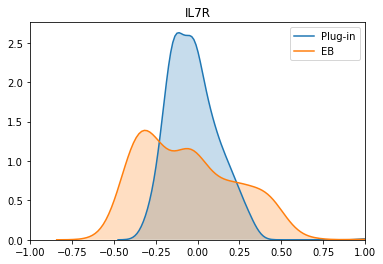

dd(+): ['TMEM123', 'SPOCK2', 'TRAT1', 'AAK1', 'RPL14']
dd(-): ['POMP', 'RHOA', 'LY86', 'LAMTOR1', 'COX8A']
ml(+): ['RPS3', 'IL32', 'RPS29', 'EEF1A1', 'RPL3']
ml(-): ['HLA-DRA', 'HLA-DRB1', 'TYROBP', 'CD74', 'HLA-DQB1']





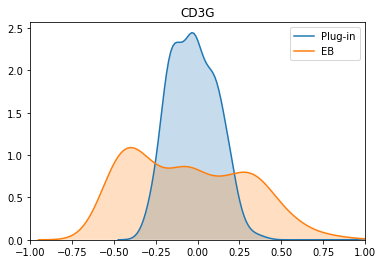

dd(+): ['LCK', 'CD3D', 'CD3E', 'LAT', 'CDC42SE2']
dd(-): ['LY86', 'POMP', 'RHOA', 'GNG5', 'CNPY3']
ml(+): ['CD3D', 'TRAC', 'CD3E', 'IL32', 'LCK']
ml(-): ['HLA-DRA', 'TYROBP', 'FCER1G', 'CD74', 'HLA-DRB1']





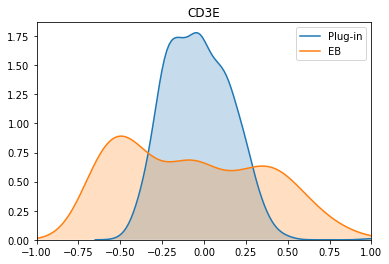

dd(+): ['LCK', 'CD3D', 'LAT', 'ACAP1', 'AAK1']
dd(-): ['LY86', 'GNG5', 'MARCH1', 'POMP', 'HLA-DMA']
ml(+): ['CD3D', 'TRAC', 'RPS29', 'IL32', 'RPS3']
ml(-): ['HLA-DRA', 'HLA-DRB1', 'CD74', 'TYROBP', 'HLA-DQB1']





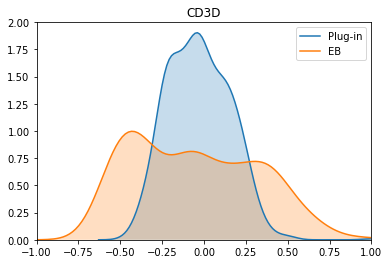

dd(+): ['LCK', 'CD3E', 'CD3G', 'LAT', 'CD27']
dd(-): ['LY86', 'MARCH1', 'SERP1', 'ATP6V0B', 'CNPY3']
ml(+): ['TRAC', 'CD3E', 'IL32', 'LCK', 'CD3G']
ml(-): ['HLA-DRA', 'TYROBP', 'CD74', 'HLA-DRB1', 'FCER1G']





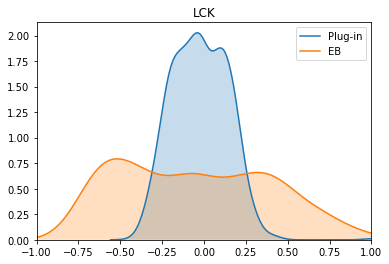

dd(+): ['ACAP1', 'HMHA1', 'CD3D', 'CD3E', 'LAT']
dd(-): ['LY86', 'CTSH', 'MARCH1', 'ATP6V0B', 'HLA-DMA']
ml(+): ['CD3D', 'IL32', 'TRAC', 'CD3E', 'HLA-A']
ml(-): ['HLA-DRA', 'FTL', 'HLA-DRB1', 'CD74', 'CTSS']





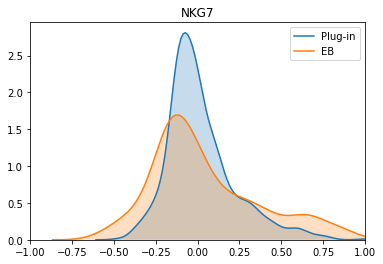

dd(+): ['APMAP', 'CST7', 'ABHD17A', 'GZMM', 'APOBEC3G']
dd(-): ['RPL39', 'COX4I1', 'RPS9', 'UBA52', 'RPL26']
ml(+): ['CST7', 'GZMA', 'PRF1', 'CTSW', 'FGFBP2']
ml(-): ['RPL39', 'RPL34', 'RPS13', 'RPL32', 'RPL12']





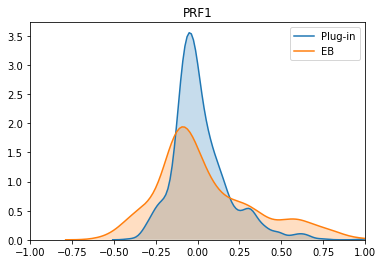

dd(+): ['APMAP', 'CD247', 'ABHD17A', 'NKG7', 'SPON2']
dd(-): ['UBA52', 'RPL39', 'RPS9', 'RPL26', 'RPL12']
ml(+): ['NKG7', 'FGFBP2', 'SPON2', 'GZMA', 'CST7']
ml(-): ['RPL39', 'RPL34', 'RPL32', 'RPL18A', 'RPL12']





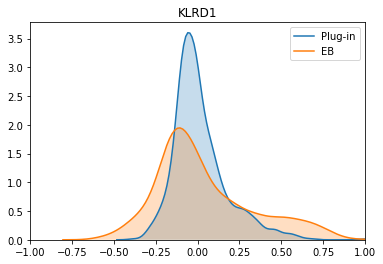

dd(+): ['ABHD17A', 'NKG7', 'XCL2', 'CTSW', 'MATK']
dd(-): ['UBA52', 'RPL39', 'COX4I1', 'RPL26', 'RPS9']
ml(+): ['NKG7', 'GNLY', 'CTSW', 'CST7', 'PRF1']
ml(-): ['RPL39', 'RPL34', 'RPL32', 'RPL12', 'RPS13']





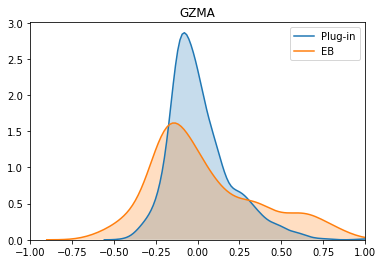

dd(+): ['APMAP', 'APOBEC3G', 'CST7', 'CHST12', 'NKG7']
dd(-): ['COX4I1', 'UBA52', 'RPS9', 'RPL39', 'EIF3H']
ml(+): ['NKG7', 'CST7', 'PRF1', 'CTSW', 'HLA-B']
ml(-): ['RPL39', 'RPS13', 'RPL34', 'RPL32', 'RPS3A']





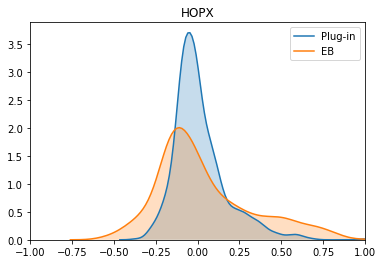

dd(+): ['APMAP', 'CHST12', 'CTSW', 'ABHD17A', 'NKG7']
dd(-): ['UBA52', 'EIF3H', 'RPL39', 'RPS9', 'RPL26']
ml(+): ['NKG7', 'GNLY', 'CTSW', 'PRF1', 'CST7']
ml(-): ['RPL39', 'RPL34', 'RPS13', 'RPL18A', 'RPL11']





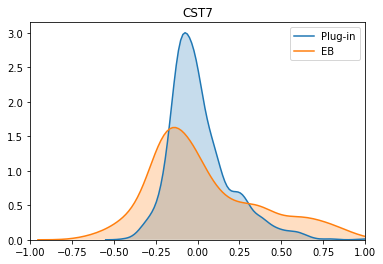

dd(+): ['NKG7', 'CHST12', 'APMAP', 'GZMM', 'ARPC5L']
dd(-): ['COX4I1', 'UBA52', 'RPS9', 'EIF3H', 'RPL39']
ml(+): ['NKG7', 'GZMA', 'PRF1', 'CTSW', 'CCL5']
ml(-): ['RPL39', 'RPS13', 'RPL34', 'RPL12', 'RPL32']





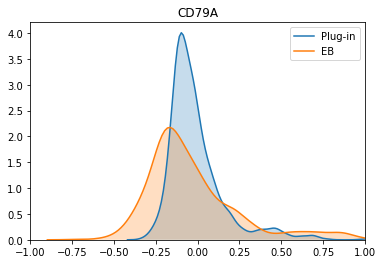

dd(+): ['TNFRSF13C', 'CD79B', 'BANK1', 'CD37', 'RALGPS2']
dd(-): ['ATP5L', 'ABRACL', 'FYB', 'RPS26', 'AAK1']
ml(+): ['CD79B', 'IGHM', 'IGHD', 'MS4A1', 'CD37']
ml(-): ['TMSB4X', 'HCST', 'S100A4', 'B2M', 'FYB']





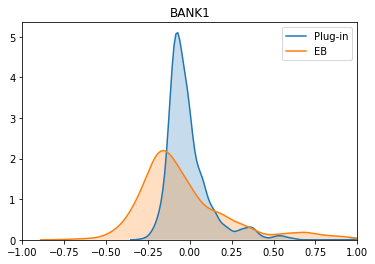

dd(+): ['TNFRSF13C', 'SNX2', 'CD79A', 'CD37', 'CD79B']
dd(-): ['ATP5L', 'RPS26', 'ABRACL', 'AAK1', 'FYB']
ml(+): ['CD79A', 'CD79B', 'IGHM', 'MS4A1', 'CD37']
ml(-): ['TMSB4X', 'HCST', 'B2M', 'CD3E', 'FYB']





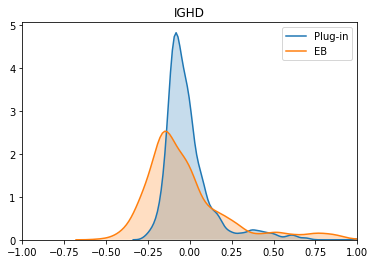

dd(+): ['FCER2', 'HVCN1', 'LINC00926', 'CD37', 'CD79B']
dd(-): ['ATP5L', 'ABRACL', 'FYB', 'UQCRB', 'AAK1']
ml(+): ['CD79A', 'CD79B', 'TCL1A', 'CD37', 'LINC00926']
ml(-): ['TMSB4X', 'B2M', 'HCST', 'S100A4', 'TPT1']





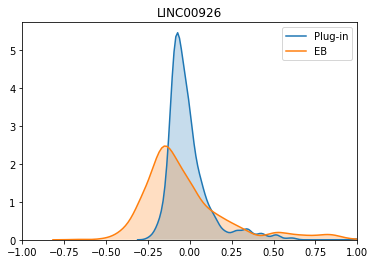

dd(+): ['FCER2', 'IGHD', 'BANK1', 'SNX2', 'CD79A']
dd(-): ['ATP5L', 'ABRACL', 'RPS26', 'TMA7', 'SSR4']
ml(+): ['IGHD', 'CD79A', 'CD79B', 'IGHM', 'CD37']
ml(-): ['TMSB4X', 'B2M', 'HCST', 'S100A4', 'CD3E']





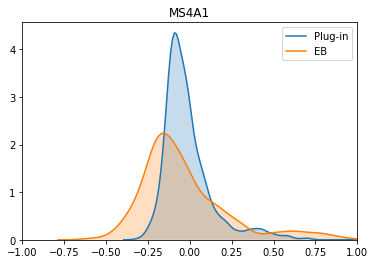

dd(+): ['TNFRSF13C', 'CD79B', 'BANK1', 'CD79A', 'HVCN1']
dd(-): ['ATP5L', 'RPS26', 'ABRACL', 'FYB', 'AAK1']
ml(+): ['CD79B', 'CD79A', 'CD74', 'IGHD', 'CD37']
ml(-): ['TMSB4X', 'HCST', 'FYB', 'S100A4', 'B2M']





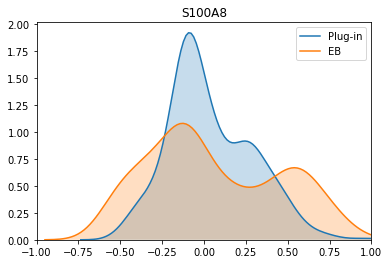

dd(+): ['S100A9', 'GCA', 'C14orf2', 'S100A12', 'SDCBP']
dd(-): ['ACAP1', 'RPL23A', 'EIF3F', 'RPL27A', 'TSTD1']
ml(+): ['S100A9', 'S100A12', 'LYZ', 'S100A6', 'MNDA']
ml(-): ['RPS29', 'RPS27', 'RPL23A', 'RPL3', 'RPS3']





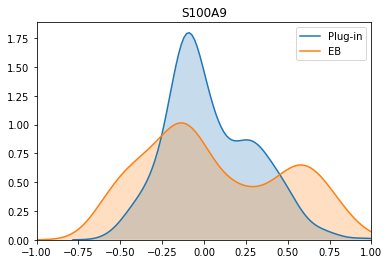

dd(+): ['S100A8', 'GCA', 'METTL9', 'C14orf2', 'MGST1']
dd(-): ['TSTD1', 'ACAP1', 'RPL23A', 'CIRBP', 'EVL']
ml(+): ['S100A8', 'LYZ', 'S100A12', 'S100A6', 'VCAN']
ml(-): ['RPS29', 'RPS27', 'RPL23A', 'RPL3', 'RPS3']





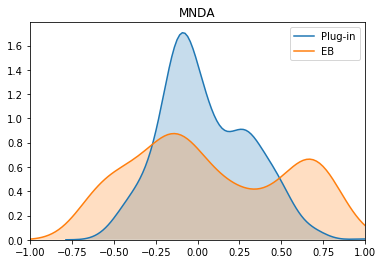

dd(+): ['GCA', 'ATP6V0B', 'SDCBP', 'AP2S1', 'C4orf48']
dd(-): ['ACAP1', 'TSTD1', 'RPL23A', 'EIF3F', 'EVL']
ml(+): ['LYZ', 'S100A8', 'S100A9', 'S100A6', 'CTSS']
ml(-): ['RPS29', 'RPS27', 'RPL23A', 'RPL3', 'RPS3']





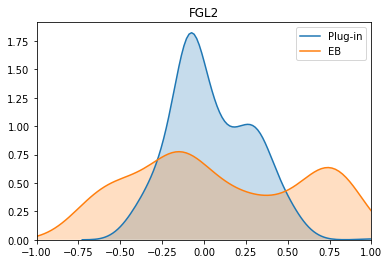

dd(+): ['AP2S1', 'PCBP1', 'FGL2', 'FKBP1A', 'POMP']
dd(-): ['ACAP1', 'VAMP2', 'TSTD1', 'RPL23A', 'RPSA']
ml(+): ['CTSS', 'FTL', 'TYROBP', 'LYZ', 'S100A6']
ml(-): ['RPS29', 'RPS27', 'RPL3', 'RPL23A', 'RPS3']





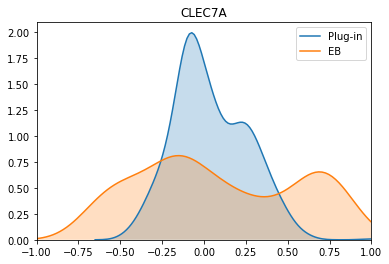

dd(+): ['CLEC12A', 'PCBP1', 'SERP1', 'CPPED1', 'CTSS']
dd(-): ['ACAP1', 'TSTD1', 'RPL23A', 'RPL3', 'VAMP2']
ml(+): ['CTSS', 'FTL', 'TYROBP', 'LYZ', 'S100A6']
ml(-): ['RPS29', 'RPS27', 'RPL3', 'RPL23A', 'RPS3']





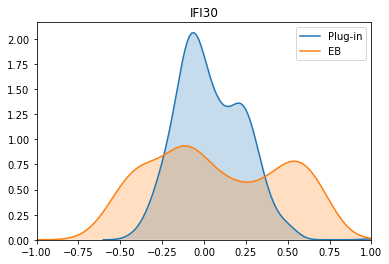

dd(+): ['COX6B1', 'FKBP1A', 'RTN4', 'ANXA5', 'COX7B']
dd(-): ['ACAP1', 'TSTD1', 'VAMP2', 'RPL23A', 'EIF4A2']
ml(+): ['LST1', 'FTL', 'CST3', 'FTH1', 'AIF1']
ml(-): ['RPS27', 'RPS29', 'RPL23A', 'RPL3', 'RPS3']





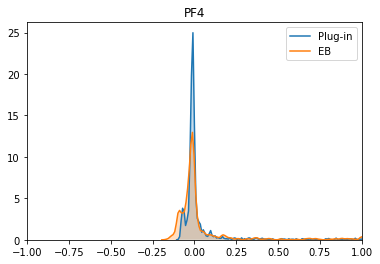

dd(+): ['ODC1', 'PF4', 'CD9', 'GP9', 'PPBP']
dd(-): ['COX4I1', 'EIF3H', 'NACA', 'RPL26', 'RPL28']
ml(+): ['PPBP', 'SDPR', 'TUBB1', 'GP9', 'GNG11']
ml(-): ['RPL28', 'RPL41', 'RPL26', 'RPL10', 'RPS15']





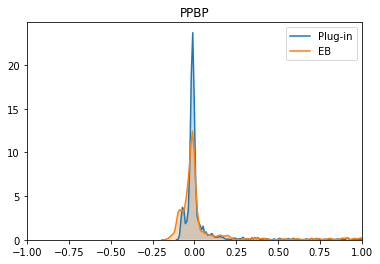

dd(+): ['PPBP', 'PF4', 'NCOA4', 'CD9', 'TUBB1']
dd(-): ['COX4I1', 'EIF3H', 'RPL28', 'RPL26', 'NACA']
ml(+): ['PF4', 'TUBB1', 'GNG11', 'SDPR', 'ACRBP']
ml(-): ['RPL28', 'RPL41', 'RPL26', 'RPL13', 'RPL11']





In [292]:
for gene in markgenes_:
    loc = np.where(gene_list==gene)[0][0]
    
    

    sns.distplot(PC_ml[loc,:],label='Plug-in',hist=0,kde_kws={'shade':1})
    sns.distplot(PC_dd[loc,:],label='EB',hist=0,kde_kws={'shade':1})
    plt.xlim([-1,1])
    plt.title(gene)
    plt.legend()
    plt.show()
    
    ii=np.argsort(PC_dd[loc])[::-1]
    print('dd(+):',list(gene_list[ii[1:6]]))
    print('dd(-):',list(gene_list[ii[::-1][:5]]))
    
    ii=np.argsort(PC_ml[loc])[::-1]
    print('ml(+):',list(gene_list[ii[1:6]]))
    print('ml(-):',list(gene_list[ii[::-1][:5]]))
    print('\n\n')



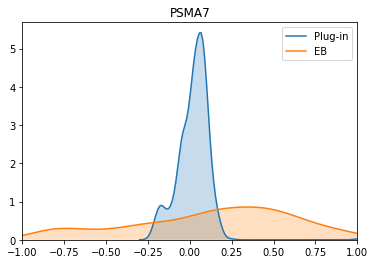

dd(+): ['COX8A', 'ARPC2', 'CAP1', 'POMP', 'PSMA7', 'COX6B1', 'RHOA', 'RHOG', 'ARPC1B', 'PGK1', 'PGAM1']
dd(-): ['EIF4B', 'NBEAL1', 'RPL13', 'RPL9', 'RPL30', 'TOMM7', 'RPS3A', 'RPL35A', 'RPL18', 'EIF3H', 'RPL21']
ml(+): ['ACTB', 'S100A4', 'GAPDH', 'PFN1', 'SH3BGRL3', 'ITGB2', 'TMSB4X', 'ARPC1B', 'S100A11', 'CLIC1', 'ANXA2']
ml(-): ['RPS27', 'RPL13', 'RPL21', 'RPS6', 'RPL32', 'RPL30', 'RPL13A', 'RPL34', 'RPS3A', 'RPLP2', 'RPL11']





In [323]:
gene='PSMA7'
loc = np.where(gene_list==gene)[0][0]



sns.distplot(PC_ml[loc,:],label='Plug-in',hist=0,kde_kws={'shade':1})
sns.distplot(PC_dd[loc,:],label='EB',hist=0,kde_kws={'shade':1})
plt.xlim([-1,1])
plt.title(gene)
plt.legend()
plt.show()

ii=np.argsort(PC_dd[loc])[::-1]
print('dd(+):',list(gene_list[ii[1:12]]))
print('dd(-):',list(gene_list[ii[::-1][:11]]))

ii=np.argsort(PC_ml[loc])[::-1]
print('ml(+):',list(gene_list[ii[1:12]]))
print('ml(-):',list(gene_list[ii[::-1][:11]]))
print('\n\n')

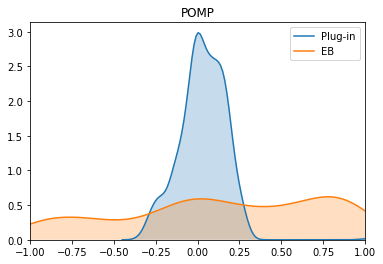

dd(+): ['CAP1', 'ENY2', 'GNG5', 'DAZAP2', 'BLOC1S1', 'RPS26', 'AP2S1', 'COX7B', 'MSN', 'POMP', 'COX6B1']
dd(-): ['RPL35A', 'RPS20', 'RPL23A', 'RPS21', 'EIF3F', 'RPS10', 'RPL14', 'RPL31', 'RPL19', 'TMEM123', 'RPS27']
ml(+): ['FTL', 'CYBA', 'TYROBP', 'FCER1G', 'SRGN', 'S100A4', 'S100A6', 'CST3', 'ACTB', 'AIF1', 'LYZ']
ml(-): ['RPS27', 'RPS29', 'RPL3', 'RPS27A', 'RPS3', 'RPL30', 'RPL31', 'RPL19', 'RPL23A', 'RPS6', 'RPS15A']





In [322]:
gene='POMP'
loc = np.where(gene_list==gene)[0][0]



sns.distplot(PC_ml[loc,:],label='Plug-in',hist=0,kde_kws={'shade':1})
sns.distplot(PC_dd[loc,:],label='EB',hist=0,kde_kws={'shade':1})
plt.xlim([-1,1])
plt.title(gene)
plt.legend()
plt.show()

ii=np.argsort(PC_dd[loc])[::-1]
print('dd(+):',list(gene_list[ii[1:12]]))
print('dd(-):',list(gene_list[ii[::-1][:11]]))

ii=np.argsort(PC_ml[loc])[::-1]
print('ml(+):',list(gene_list[ii[1:12]]))
print('ml(-):',list(gene_list[ii[::-1][:11]]))
print('\n\n')

dd: -0.5522995446606183
ml: -0.1170420024311853


Text(0,0.5,'TNFRSF13C')

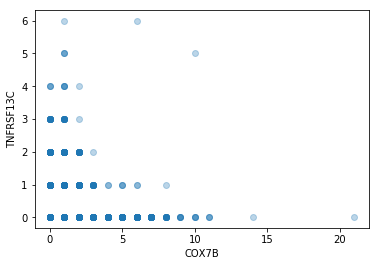

In [311]:
gene='COX7B'
gene2='TNFRSF13C'
loc = np.where(gene_list==gene)[0][0]
loc2 = np.where(gene_list==gene2)[0][0]
print('dd:',PC_dd[loc,loc2])
print('ml:',PC_ml[loc,loc2])

x1 = np.array(data[:,gene].X)
x2 = np.array(data[:,gene2].X)
plt.scatter(x1,x2,alpha=0.3)
plt.xlabel(gene)
plt.ylabel(gene2)

dd: 1.0
ml: 0.09539686872737432


Text(0,0.5,'PSMA7')

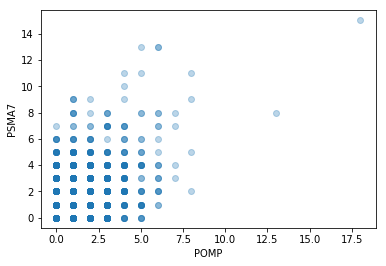

In [318]:
gene='POMP'
gene2='PSMA7'
loc = np.where(gene_list==gene)[0][0]
loc2 = np.where(gene_list==gene2)[0][0]
print('dd:',PC_dd[loc,loc2])
print('ml:',PC_ml[loc,loc2])

x1 = np.array(data[:,gene].X)
x2 = np.array(data[:,gene2].X)
plt.scatter(x1,x2,alpha=0.3)
plt.xlabel(gene)
plt.ylabel(gene2)

dd: -0.9204311399943752
ml: -0.10066675237808309


Text(0,0.5,'HMHA1')

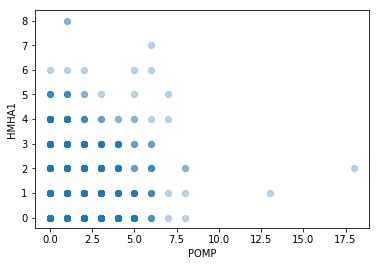

In [317]:
gene='POMP'
gene2='HMHA1'
loc = np.where(gene_list==gene)[0][0]
loc2 = np.where(gene_list==gene2)[0][0]
print('dd:',PC_dd[loc,loc2])
print('ml:',PC_ml[loc,loc2])

x1 = np.array(data[:,gene].X)
x2 = np.array(data[:,gene2].X)
plt.scatter(x1,x2,alpha=0.3)
plt.xlabel(gene)
plt.ylabel(gene2)

dd: -0.8481308032557452
ml: -0.3487367445470072


Text(0,0.5,'LY86')

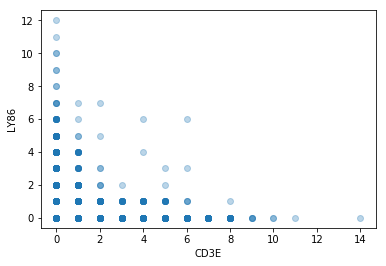

In [306]:

gene='CD3E'
gene2='LY86'
loc = np.where(gene_list==gene)[0][0]
loc2 = np.where(gene_list==gene2)[0][0]
print('dd:',PC_dd[loc,loc2])
print('ml:',PC_ml[loc,loc2])

x1 = np.array(data[:,gene].X)
x2 = np.array(data[:,gene2].X)
plt.scatter(x1,x2,alpha=0.3)
plt.xlabel(gene)
plt.ylabel(gene2)

In [154]:
## write the network file
fil=0.8
outfile = output_folder + '/data_PC_dd_var_fil_%0.2f.csv'%fil
## unweighted
temp = (PC_dd>fil).astype(int)
## weights
# temp = 1-PC_dd
# temp = temp * (PC_dd>fil)
np.fill_diagonal(temp,0)
write_NET_csv(temp,gene_list,outfile)

In [153]:
## write the network file
fil=0.5
outfile = output_folder + '/data_PC_ml_var_fil_%0.2f.csv'%fil
## unweighted
temp = (PC_dd>fil).astype(int)
## weights
# temp = 1-PC_ml
# temp = temp * (PC_ml>fil)
np.fill_diagonal(temp,0)
write_NET_csv(temp,gene_list,outfile)

dd: 0.08519093553032414
ml: 0.01567088375989792


Text(0,0.5,'CD3G')

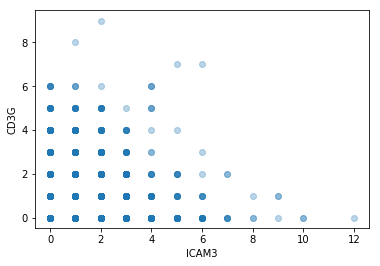

In [343]:
gene='ICAM3'
gene2='CD3G'
loc = np.where(gene_list==gene)[0][0]
loc2 = np.where(gene_list==gene2)[0][0]
print('dd:',PC_dd[loc,loc2])
print('ml:',PC_ml[loc,loc2])

x1 = np.array(data[:,gene].X)
x2 = np.array(data[:,gene2].X)
plt.scatter(x1,x2,alpha=0.3)
plt.xlabel(gene)
plt.ylabel(gene2)

In [324]:
PCnn_diff = np.abs(PC_dd - PC_ml)

In [326]:
np.sum(PCnn_diff>0.85)

362

In [329]:
for i in range(len(gene_list)):
    for j in range(i+1,len(gene_list)):
        if PCnn_diff[i,j]<0.85:
            gene = gene_list[i]
            gene2 = gene_list[j]
            print(gene,gene2)
            print('dd:',PC_dd[i,j])
            print('ml:',PC_ml[i,j])
            print()

ENO1 MYL12B
dd: 1.0
ml: 0.12501710168428534

CAPZB CAP1
dd: 0.996977837999219
ml: 0.11357690595645271

CAPZB TPM3
dd: 1.0
ml: 0.1210925016088217

CAPZB YWHAQ
dd: 0.9676479369739037
ml: 0.10321743449756458

CAPZB ARL6IP5
dd: 0.9544840911412862
ml: 0.09066443723093122

CAPZB DRAP1
dd: 1.0
ml: 0.09679825648207796

CAPZB PPP1CA
dd: 1.0
ml: 0.10694630372116032

CAPZB TBC1D10C
dd: 1.0
ml: 0.12829984343423842

CAPZB MYL12B
dd: 1.0
ml: 0.12240254815175924

CAPZB RAC2
dd: 1.0
ml: 0.14241723093494474

CDA ATP5L
dd: 1.0
ml: 0.1484438845613622

PTP4A2 TPM3
dd: 1.0
ml: 0.12258109221667915

PTP4A2 SEC61G
dd: 0.9922754647982509
ml: 0.14018255212370354

PTP4A2 DAZAP2
dd: 1.0
ml: 0.14072769402695018

CAP1 TPM3
dd: 1.0
ml: 0.13303194310424715

CAP1 POMP
dd: 1.0
ml: 0.1434221446937967

CAP1 PSMA7
dd: 1.0
ml: 0.12167037810703596

PPT1 COX6B1
dd: 1.0
ml: 0.14296187065309657

GNG5 PCBP1
dd: 1.0
ml: 0.1202931841887163

GNG5 COX5B
dd: 1.0
ml: 0.12500868142582847

GNG5 MSN
dd: 1.0
ml: 0.14494623045227573

GNG5

In [340]:
for i in range(len(gene_list)):
    for j in range(i+1,len(gene_list)):
        if PCnn_diff[i,j]<0.85:
            if PCnn_diff[i,j]>0.7:
                gene = gene_list[i]
                gene2 = gene_list[j]
                print(gene,gene2)
                print('dd:',PC_dd[i,j])
                print('ml:',PC_ml[i,j])
                print()

ENO1 LDHA
dd: 0.8475735640312693
ml: 0.1277253604128818

ENO1 PSMA7
dd: 0.8344748619911895
ml: 0.0935419262752037

TNFRSF1B SERP1
dd: 0.8357425565072317
ml: 0.13571869801455042

TNFRSF1B MSN
dd: 0.8637385176985207
ml: 0.16044242540547807

TNFRSF1B COX6B1
dd: 0.8314016402342556
ml: 0.12735187587042704

CAPZB ARPC2
dd: 0.8554359500738304
ml: 0.1366968150629616

CAPZB PSMB9
dd: 0.8225997395478766
ml: 0.08832081344307913

CAPZB SEPT7
dd: 0.865597132242703
ml: 0.11501679608815384

CAPZB RBM3
dd: 0.8765322359388344
ml: 0.06720976082378444

CAPZB IL2RG
dd: 0.8827457957304389
ml: 0.11347763744187034

CAPZB RPL39
dd: -0.9312000919691907
ml: -0.21584140623248585

CAPZB DOK2
dd: 0.846830002643299
ml: 0.11872281070141014

CAPZB FAU
dd: -0.8716814501444154
ml: -0.10801776612753881

CAPZB CFL1
dd: 1.0
ml: 0.2080922487723803

CAPZB ARHGDIB
dd: 1.0
ml: 0.1649968106613777

CAPZB BIN2
dd: 0.8678458162719593
ml: 0.11233213299870606

CAPZB RAP1B
dd: 0.8955325272366197
ml: 0.13135770581608022

CAPZB CORO1A

ml: -0.09472400505478959

RTN4 AP2S1
dd: 1.0
ml: 0.1976152934490014

RTN4 RBX1
dd: 0.9175928877683758
ml: 0.11952196110615004

RPS27A POMP
dd: -1.0
ml: -0.29845979301475734

ACTR2 PCBP1
dd: 0.9010822137674805
ml: 0.09908102305027236

ACTR2 COX5B
dd: 0.8075824427396338
ml: 0.09399307523445688

ACTR2 ZEB2
dd: 0.8991565958707389
ml: 0.18399128374970822

ACTR2 RHOA
dd: 0.9390691558587917
ml: 0.15410738002909308

ACTR2 GNAI2
dd: 0.8527562331253751
ml: 0.1387499854207938

ACTR2 SERP1
dd: 0.8441928617521433
ml: 0.10040886218700511

ACTR2 SEC61G
dd: 0.956835327815226
ml: 0.13203226930864842

ACTR2 RBM3
dd: 0.7932656168651111
ml: 0.076225420200791

ACTR2 MSN
dd: 0.9461700218870939
ml: 0.1287269022295142

ACTR2 POLR2L
dd: 0.8962371543486994
ml: 0.16803231409503538

ACTR2 RHOG
dd: 0.8641462165393993
ml: 0.1125462404473461

ACTR2 COX8A
dd: 0.8290670778043046
ml: 0.10233239199564116

ACTR2 LAMTOR1
dd: 0.8448012575954307
ml: 0.11000646168279307

ACTR2 CASP1
dd: 0.8681604175888579
ml: 0.1614389332532

ml: 0.10079915342317129

ARPC4 COX8A
dd: 0.8248871192652556
ml: 0.09670500797983667

ARPC4 DRAP1
dd: 0.7962111417534584
ml: 0.09173032079958064

ARPC4 EIF4B
dd: -0.8492752913393827
ml: -0.08076859738541446

ARPC4 POMP
dd: 0.8854914739350046
ml: 0.10288095173582087

ARPC4 EIF5A
dd: 0.8121103805815487
ml: 0.08986212139459182

ARPC4 ABI3
dd: 0.9037290171368956
ml: 0.1672714854891733

ARPC4 MYL12B
dd: 0.9272884239575787
ml: 0.09926621222188575

ARPC4 RPL17
dd: -0.8874488522622539
ml: -0.14231693299603884

ARPC4 YWHAB
dd: 0.9089614126795635
ml: 0.08912949554490376

ARPC4 PSMA7
dd: 0.9120443231266149
ml: 0.08816175290035681

ARPC4 MYO1F
dd: 0.9404187757204379
ml: 0.19285986281589088

ARPC4 VASP
dd: 0.880109091441931
ml: 0.1391942913641162

RPL15 EIF3F
dd: 0.891586289711957
ml: 0.14520117308441038

CMTM6 RHOA
dd: 0.8879636480838039
ml: 0.1717034567289323

CMTM6 POMP
dd: 0.8392118561075185
ml: 0.12096206825553597

RPL14 ATP6V0E1
dd: -0.9342282196045454
ml: -0.20936964947687223

RPL14 EIF3F
dd:

ml: 0.2129448784083981

RNF130 COX8A
dd: 0.9159086291658632
ml: 0.1960561022474074

RNF130 POMP
dd: 0.9602305381762006
ml: 0.20370414845535126

RNF130 COX6B1
dd: 0.9492368980996915
ml: 0.1846873037881297

GNB2L1 EIF3H
dd: 0.9690521629905429
ml: 0.12677743847598663

GNB2L1 EIF3F
dd: 0.8719653793778289
ml: 0.121714935974127

GNB2L1 EIF4B
dd: 0.9640188607807328
ml: 0.15403422036526876

GNB2L1 CKLF
dd: -0.8942729496812852
ml: -0.18697358537920375

SERPINB1 TALDO1
dd: 0.9783630130569517
ml: 0.22208116025200894

SERPINB1 COX8A
dd: 0.8314400167044368
ml: 0.12461848599278974

FAM65B RPS26
dd: -0.7777927563064768
ml: -0.07328536400041756

HLA-F COX4I1
dd: -0.8706920507882413
ml: -0.07819327589882814

HLA-E COX4I1
dd: -0.8185915561483968
ml: -0.118569308324631

HLA-E ARHGEF1
dd: 0.9106327615459089
ml: 0.1975833263236244

PPP1R18 MYL12B
dd: 0.9435581645452366
ml: 0.11494370404410774

PPP1R18 APMAP
dd: 0.9305116933956017
ml: 0.1980327902189875

HLA-C MYL12B
dd: 1.0
ml: 0.26429079629285007

HLA-B M

dd: 1.0
ml: 0.2414497079068377

COX7B CHP1
dd: 0.907199874229148
ml: 0.15285607456792957

COX7B SERF2
dd: 1.0
ml: 0.2290152864503412

COX7B SEC11A
dd: 0.9807247964170356
ml: 0.1393128710802733

COX7B TCEB2
dd: 1.0
ml: 0.20841055203400743

COX7B CPPED1
dd: 0.8778164673431329
ml: 0.1650979706989114

COX7B ALDOA
dd: 0.9845948340367189
ml: 0.15198559420750873

COX7B PYCARD
dd: 0.9877035906042286
ml: 0.21490460276876253

COX7B CKLF
dd: 0.8735224295103546
ml: 0.10664100805795033

COX7B ACAP1
dd: -0.9014918368055163
ml: -0.13809474120478102

COX7B VAMP2
dd: -0.8053035532488865
ml: -0.08746731051386962

COX7B RPL23A
dd: -1.0
ml: -0.2874317307244683

COX7B GRN
dd: 0.9872811660053058
ml: 0.2593762648490033

COX7B VMP1
dd: 0.9642358116981641
ml: 0.1503811076403782

COX7B FKBP1A
dd: 1.0
ml: 0.2455598343680662

COX7B SAMHD1
dd: 0.9273748450724386
ml: 0.14635435010484885

COX7B ATP5E
dd: 1.0
ml: 0.2334069565205614

COX7B RPS21
dd: -0.9874345209604208
ml: -0.2269593568983888

COX7B CIRBP
dd: -0.95059


ATP5L GAPDH
dd: 0.9565869580036085
ml: 0.19390274623242168

ATP5L C14orf2
dd: 0.907919316589138
ml: 0.14212382046773084

ATP5L CHP1
dd: 0.8247447219634797
ml: 0.10148604679394

ATP5L SEC11A
dd: 0.7944091318897459
ml: 0.08241293556177255

ATP5L IQGAP1
dd: 0.8177529208733038
ml: 0.0961625497678158

ATP5L PYCARD
dd: 0.8494396130171491
ml: 0.13497665599144518

ATP5L SAMHD1
dd: 0.8224919791359433
ml: 0.09479579324962584

ATP5L CTSZ
dd: 0.8301578354190887
ml: 0.11956450606238782

ATP5L ATP5E
dd: 0.912736126307791
ml: 0.14792011713667483

ATP5L PGLS
dd: 0.8697592838414839
ml: 0.08864120336697065

ATP5L EIF3K
dd: 0.7535981929530099
ml: 0.049674865586103054

RPS25 POMP
dd: -1.0
ml: -0.2779264933935357

ETS1 DAZAP2
dd: -0.8144338141578695
ml: -0.11252002873395713

ETS1 ARHGEF1
dd: 0.9037742223742702
ml: 0.12998376127777284

APLP2 POMP
dd: 0.9138199425617141
ml: 0.16942387928028538

SRGN POMP
dd: 1.0
ml: 0.28271076265508716

C10orf54 BLOC1S1
dd: 0.8552419057230475
ml: 0.14524491873424614

C10orf

dd: 1.0
ml: 0.14519732755190495


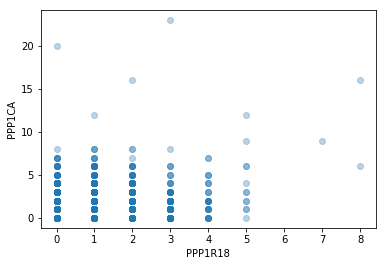

dd: 0.9774765328465399
ml: 0.12113490660747579


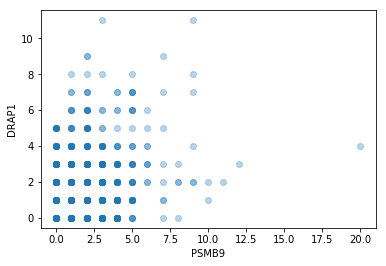

dd: 0.988969301598445
ml: 0.10721069579937641


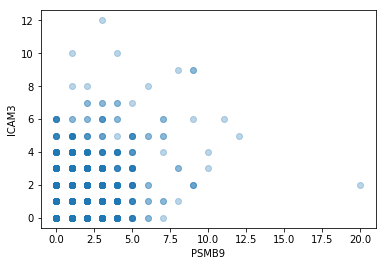

dd: 0.9434107016433186
ml: 0.0700540652391336


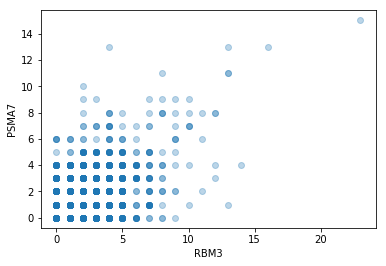

dd: -1.0
ml: -0.09183292848243461


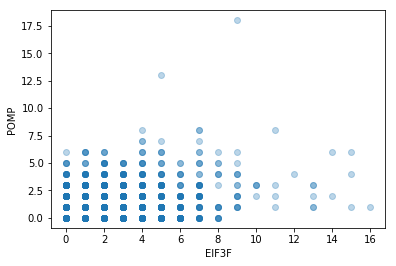

dd: 0.926059816686596
ml: 0.06788901720140948


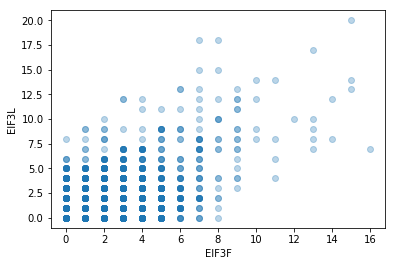

dd: 1.0
ml: 0.11555414320128025


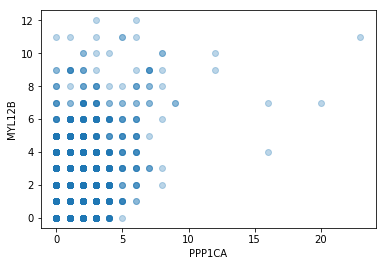

In [331]:
lst=[['PPP1R18', 'PPP1CA'],
['PSMB9', 'DRAP1'],
['PSMB9', 'ICAM3'],
['RBM3', 'PSMA7'],
['EIF3F', 'POMP'],
['EIF3F' ,'EIF3L'],
['PPP1CA', 'MYL12B']]

CD53 PPP1CA

for l in lst:
    gene,gene2=l
    loc = np.where(gene_list==gene)[0][0]
    loc2 = np.where(gene_list==gene2)[0][0]
    print('dd:',PC_dd[loc,loc2])
    print('ml:',PC_ml[loc,loc2])

    x1 = np.array(data[:,gene].X)
    x2 = np.array(data[:,gene2].X)
    plt.scatter(x1,x2,alpha=0.3)
    plt.xlabel(gene)
    plt.ylabel(gene2)
    plt.show()

In [241]:
data = dl.load_10x_4k()
data.var_names_make_unique()
sc.pp.filter_genes(data,min_counts=0.00001*data.shape[0])
size_factor = sd.dd_size_factor(data,verbose=False)

gene_list = np.array(data.var_names)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [280]:
markgenes_=[str(i) for sublist in marker_gene_dic.values() for i in sublist if i in gene_list]

In [243]:
data2=data[:,markgenes_]

In [244]:


# smp=np.where(size_factor>0)[0]
# data2=data2[smp,:]
# size_factor = sd.dd_size_factor(data2,verbose=False)


gene_list = np.array(markgenes_)

In [245]:
Nc,G,Nr,Nr_bar = sd.get_info(data2)

## Nc=4340, G=24, Nr=40.84, Nr_bar=1.70


In [246]:
# calculate PC
mean_ml,cov_ml,PC_ml  = sd.ml_covariance(data2,size_factor=size_factor)
mean_dd,cov_dd,PC_dd  = sd.dd_covariance(data2,size_factor=size_factor,PC_prune=False)

#time start: 0.0s
n_cell=4340, n_gene=24, Nr=40.8
#total: 0.01s
#time start: 0.0s
n_cell=4340, n_gene=24, Nr=40.8
#total: 0.01s


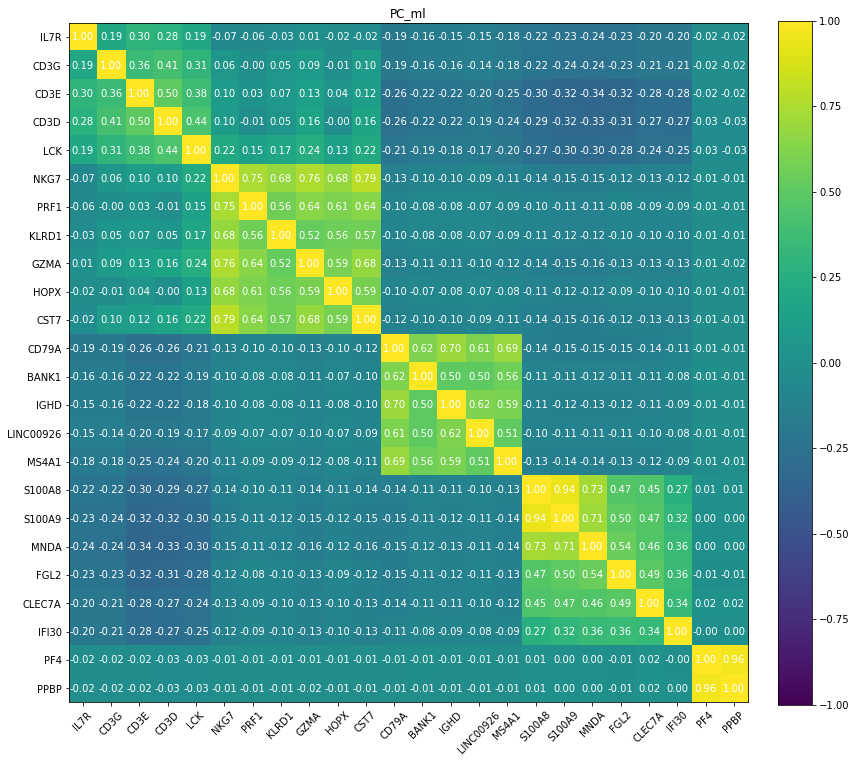

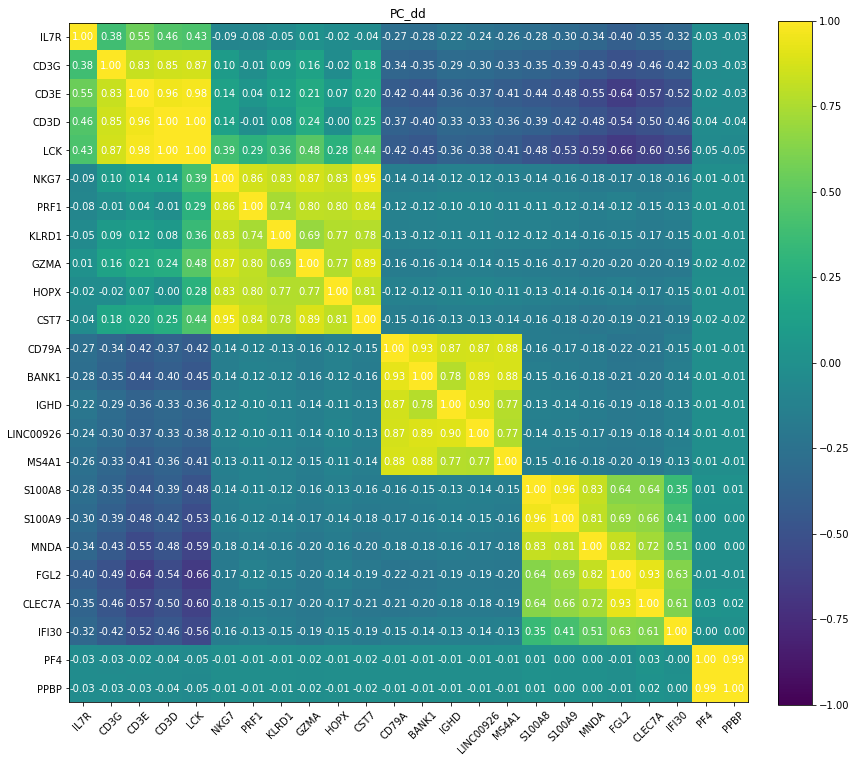

In [247]:
## visualization 
## marker gene
marker_gene_dic = {} 
marker_gene_dic['T-cells']= ['IL7R','CD3G','CD3E','CD3D','LCK']
marker_gene_dic['NK-cells']= ['NKG7','PRF1','KLRD1','GZMA','HOPX','CST7']
marker_gene_dic['B-cells']= ['CD79A','BANK1','IGHD','LINC00926','MS4A1']
marker_gene_dic['myeloid']= ['S100A8','S100A9']
marker_gene_dic['Innate Immunity']= ['MNDA','FGL2','CLEC7A','CD6S','IFI30']
marker_gene_dic['Megakaryocytes']= ['PF4','PPBP']
# marker_gene_dic['house keeping'] = ['RPL18', 'RPL13', 'RPL10A']
# marker_gene_dic['mt'] = ['MT-ND4', 'MT-ATP6', 'MT-ND1', 'MT-ND3', 'MT-CO3', 'MT-CO2',
#         'MT-CO1', 'MT-CYB', 'MT-ND2', 'MT-ND5', 'MT-ND4L']

marker_gene_heatmap(marker_gene_dic,gene_list,PC_ml,title='PC_ml')
marker_gene_heatmap(marker_gene_dic,gene_list,PC_dd,title='PC_dd')

In [254]:
from sklearn.manifold import MDS

In [257]:
tsne=MDS(n_components=2,dissimilarity='precomputed')

In [278]:
markgenes_=gene_list

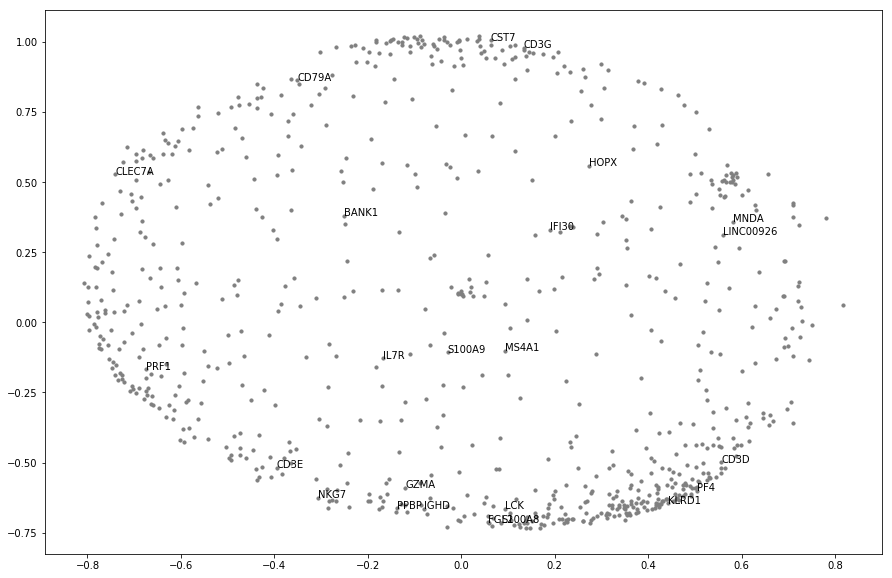

In [281]:
X_tsne=tsne.fit_transform(1-PC_dd)
X_se=X_tsne
plt.figure(figsize=[15,10])
dim1,dim2=0,1
plt.scatter(X_se[:,dim1],X_se[:,dim2],s=10,c='gray')
for i in range(len(markgenes_)):
    plt.annotate(markgenes_[i],xy=(X_se[i,dim1],X_se[i,dim2]))
plt.show()

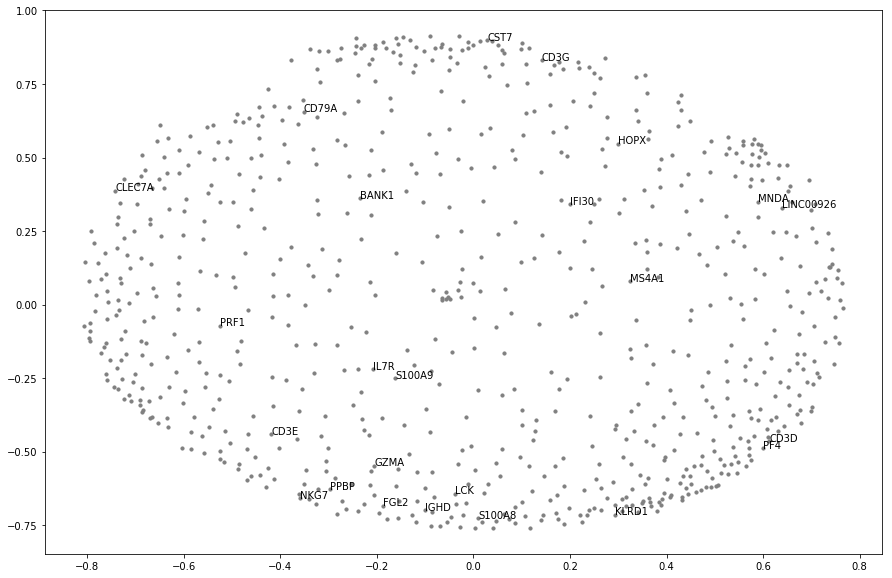

In [284]:
# X_tsne=tsne.fit_transform(1-PC_ml)
# X_se=X_tsne
plt.figure(figsize=[15,10])
dim1,dim2=0,1
plt.scatter(X_se[:,dim1],X_se[:,dim2],s=10,c='gray')
for i in range(len(markgenes_)):
    plt.annotate(markgenes_[i],xy=(X_se[i,dim1],X_se[i,dim2]))
plt.show()

# other code

In [169]:
## MI using smoothed zero probability 
# size_factor = sd.dd_size_factor(data,verbose=False)
p0_ml,p0_dd = sd.dd_inactive_prob(data,relative_depth=1.25,size_factor=size_factor,verbose=True)
zero_matrix_ml,zero_matrix_dd = \
sd.dd_pairwise_inactive_prob(data,relative_depth=1.25,size_factor=size_factor,verbose=True)
smi_ml = sd.zero_to_mi(zero_matrix_ml,up_reg_gene=True) # zero probability to mi matrix 
smi_dd = sd.zero_to_mi(zero_matrix_dd,up_reg_gene=True)

# time start: 0.0s
n_cell=4340, n_gene=791
# total time: 0.1s
# time start: 0.0s
n_cell=4340, n_gene=791
# total time: 10.4s


In [164]:
## Compute the MI matrix 
p0_ml, p0_dd = sd.dd_zero_prob(data) # marginal zero probability
zero_matrix_ml,zero_matrix_dd = sd.dd_pairwise_zero_prob(data) # pairwise zero probability
mi_ml = sd.zero_to_mi(zero_matrix_ml,up_reg_gene=True) # zero probability to mi matrix 
mi_dd = sd.zero_to_mi(zero_matrix_dd,up_reg_gene=True)

# time start: 0.0s
n_cell=4340, n_gene=791
# total time: 0.1s
#time start: 0.0s
n_cell=4340, n_gene=791
# time start: 0.0s
n_cell=4340, n_gene=791
# total time: 0.1s
# total time: 9.604s


# Network analysis

In [88]:
## mi_dd
adj_mi_dd = smi_dd>0.1
np.fill_diagonal(adj_mi_dd,0)
mod_mi_dd = mod_analysis(adj_mi_dd,gene_list,G_name='mi_dd')

## mi_ml
adj_mi_ml = mi_ml>0.02
np.fill_diagonal(adj_mi_ml,0)
mod_mi_ml = mod_analysis(adj_mi_ml,gene_list,G_name='mi_ml')

## PC_dd
adj_PC_dd = PC_dd>0.75
np.fill_diagonal(adj_PC_dd,0)
mod_PC_dd = mod_analysis(adj_PC_dd,gene_list,G_name='PC_dd')

## PC_ml
adj_PC_ml = PC_ml>0.2
np.fill_diagonal(adj_PC_ml,0)
mod_PC_ml = mod_analysis(adj_PC_ml,gene_list,G_name='PC_ml')

Graph mi_dd, n_node=2133, n_edge=2540
Module 0, size=124
Module 1, size=120
Module 2, size=87
Module 3, size=76
Module 4, size=71
Module 5, size=57
Module 6, size=52
Module 7, size=41
Module 8, size=37
Module 9, size=25
Module 10, size=22
Graph mi_ml, n_node=2133, n_edge=21997
Module 0, size=220
Module 1, size=165
Module 2, size=139
Module 3, size=58
Graph PC_dd, n_node=2133, n_edge=9096
Module 0, size=206
Module 1, size=154
Module 2, size=88
Module 3, size=53
Module 4, size=30
Module 5, size=24
Module 6, size=10
Graph PC_ml, n_node=2133, n_edge=29893
Module 0, size=368
Module 1, size=225
Module 2, size=171
Module 3, size=72
Module 4, size=37


# Check the marker genes 

In [47]:
## PC_dd
adj_ = PC_ml>0.2
np.fill_diagonal(adj_,0)
mod_ = mod_analysis(adj_,gene_list,G_name='PC_dd')

Graph PC_dd, n_node=1234, n_edge=15740
Module 0, size=310
Module 1, size=128
Module 2, size=123
Module 3, size=79
Module 4, size=60
Module 5, size=40


In [48]:
check_marker_genes(mod_,marker_gene_dic)

## Module T-cells
   IL7R: module 2
   CD3G: module 2
   CD3E: module 2
   CD3D: module 2
   LCK: module 2
 
## Module NK-cells
   NKG7: module 1
   PRF1: module 1
   KLRD1: module 1
   GZMA: module 1
   HOPX: module 1
   CST7: module 1
 
## Module B-cells
   CD79A: module 3
   BANK1: module 3
   IGHD: module 3
   LINC00926: module 3
   MS4A1: module 3
 
## Module myeloid
   S100A8: module 0
   S100A9: module 0
 
## Module Innate Immunity
   MNDA: module 0
   FGL2: module 0
   CLEC7A: module 0
   IFI30: module 0
 
## Module Megakaryocytes
   PF4: module 4
   PPBP: module 4
 
## Module house keeping
   RPL18: module 2
   RPL13: module 2
   RPL10A: module 2
 
## Module mt
   MT-ND4: module 0
   MT-ATP6: module 0
   MT-ND1: module 0
   MT-ND3: module 0
   MT-CO3: module 0
   MT-CO2: module 0
   MT-CO1: module 0
   MT-CYB: module 0
   MT-ND2: module 0
   MT-ND5: module 0
   MT-ND4L: module 0
 


In [373]:
for fil in [0.6,0.65,0.7,0.75,0.8,0.85,0.9]:
    outfile = output_folder + '/data_PC_dd_var_fil_%0.2f.csv'%fil
    temp = (PC_dd>fil).astype(int)
    np.fill_diagonal(temp,0)
    write_NET_csv(temp,gene_list,outfile)

In [358]:
outfile = output_folder + '/data_PC_ml_var_fil_0.3.csv'
# temp = 1-PC_ml
# temp = temp*(temp<0.2)
temp = (PC_ml>0.3).astype(int)
np.fill_diagonal(temp,0)
write_NET_csv(temp,gene_list,outfile)

# heatmap

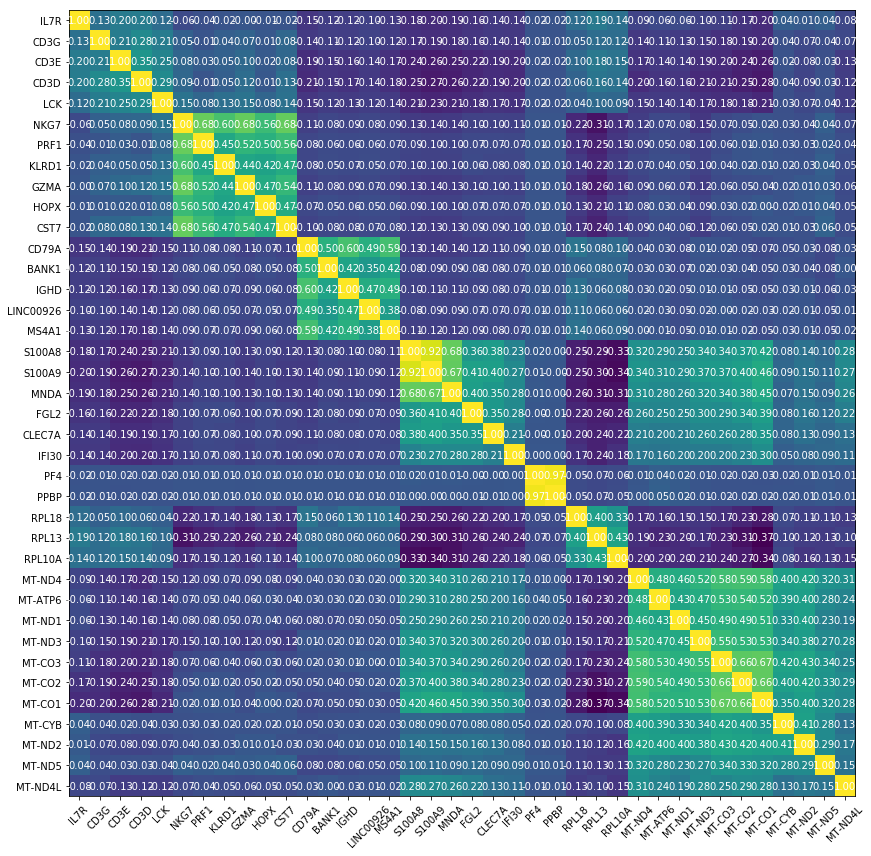

In [38]:
marker_gene_heatmap(marker_gene_dic,gene_list,PC_ml,title='')

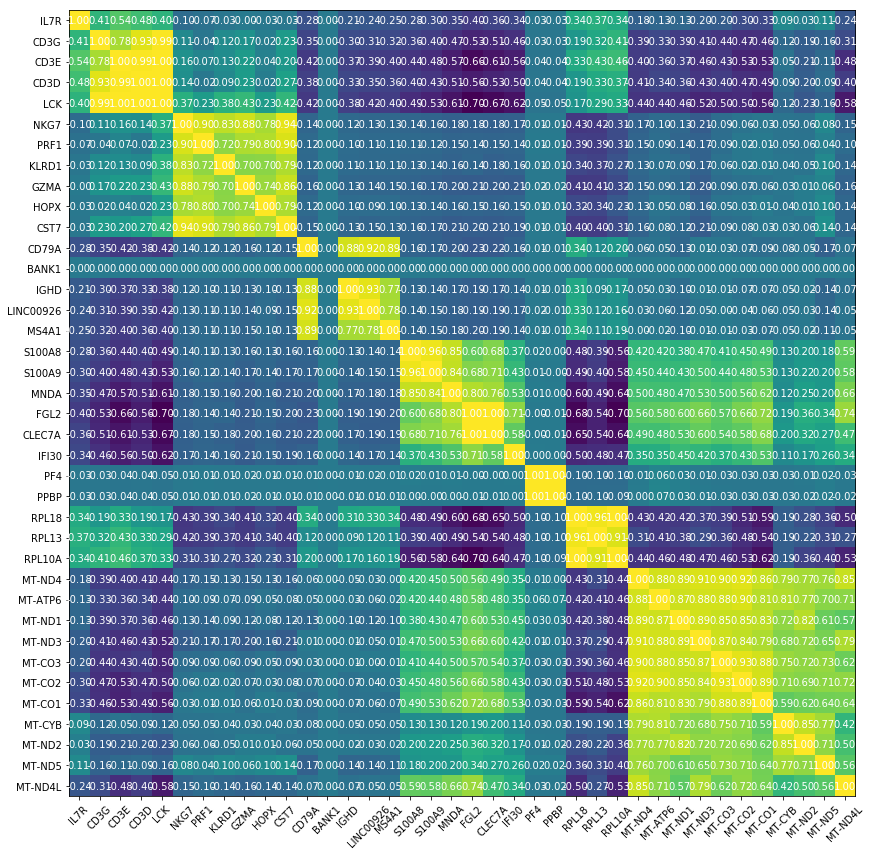

In [39]:
marker_gene_heatmap(marker_gene_dic,gene_list,PC_dd,title='')

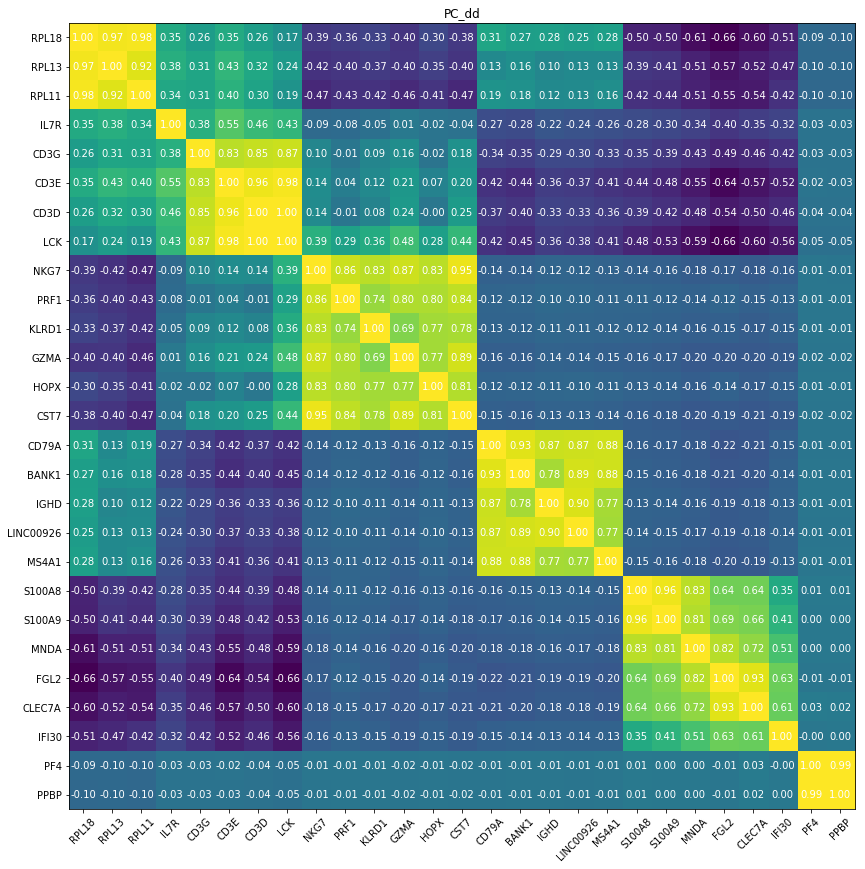

In [329]:
marker_gene_heatmap(['RPL18', 'RPL13', 'RPL11',]+temp,gene_list,PC_dd,title='PC_dd')

# old code

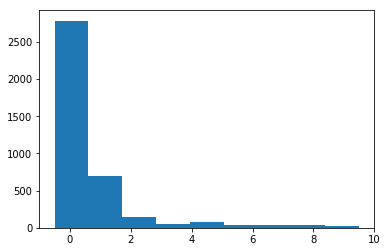

In [184]:
Y = np.array(data[:,'NKG7'].X)
plt.figure()
plt.hist(Y,bins=np.linspace(-0.5,9.5,10))
plt.show()

In [192]:
## mi_dd
adj_mi_dd = mi_dd + mi_ml>0.12
np.fill_diagonal(adj_mi_dd,0)
mod_mi_dd = mod_analysis(adj_mi_dd,gene_list,G_name='mi_dd')

Graph mi_dd, n_node=2133, n_edge=12988
Module 0, size=973
Module 1, size=519
Module 2, size=217
Module 3, size=35
Module 4, size=8


In [193]:
check_marker_genes(mod_mi_dd,marker_gene_dic)

## Module T-cells
   IL7R: module 1
   CD3G: module 1
   CD3E: module 1
   CD3D: module 1
   LCK: module 1
 
## Module NK-cells
   NKG7: module 0
   PRF1: module 0
   KLRD1: module 0
   GZMA: module 0
   HOPX: module 0
   CST7: module 0
 
## Module B-cells
   CD79A: module 3
   BANK1: module 3
   IGHD: module 3
   LINC00926: module 3
   MS4A1: module 3
 
## Module myeloid
   S100A8: module 2
 
## Module Innate Immunity
   MNDA: module 2
   FGL2: module 2
   CLEC7A: module 2
   IFI30: module 2
 
## Module HSC
 


# Dive into a toy example (PC)

In [13]:
# temp = ['IL7R','CD3G','CD3E','CD3D','LCK']
temp = ['CD3G','CD3E','CD3D','NKG7','GZMA']
temp = ['COX4I1','UBA52']
# temp = ['COX7B', 'COX6B1', 'AP2S1', 'ATP6V0B']

PC_dd = shrink_PC(cov_dd,shrink_param=0.0)
idx_ = get_index(temp,gene_list)
print(temp)
print('mean level')
print(mean_ml[idx_])
print('PC_ml')
print(PC_ml[idx_,:][:,idx_])
print('PC_dd')
print(PC_dd[idx_,:][:,idx_])
print('cov_ml')
print(cov_ml[idx_,:][:,idx_])
print('cov_dd')
print(cov_dd[idx_,:][:,idx_])

['COX4I1', 'UBA52']
mean level
[ 4.15046571 10.1551167 ]
PC_ml
[[1.         0.08746941]
 [0.08746941 1.        ]]
PC_dd
[[1. 1.]
 [1. 1.]]
cov_ml
[[ 5.17491033  0.73595911]
 [ 0.73595911 13.68019039]]
cov_dd
[[0.21819242 0.73595911]
 [0.73595911 1.55904687]]


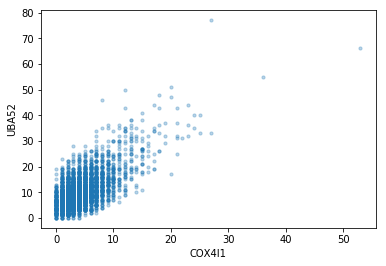

In [18]:
gene1 = 'COX4I1'
gene2 = 'UBA52'
x1 = np.array(data_full[:,gene1].X)
x2 = np.array(data_full[:,gene2].X)
plt.scatter(x1,x2,alpha=0.3,s=10)
plt.xlabel(gene1)
plt.ylabel(gene2)
plt.show()

In [21]:
Y = np.array(data_full[:,temp].X.todense())
np.corrcoef(Y.T)

array([[1.       , 0.6580848],
       [0.6580848, 1.       ]])

In [70]:
## PC_dd
adj_PC_dd = PC_dd>0.8
np.fill_diagonal(adj_PC_dd,0)
mod_PC_dd = mod_analysis(adj_PC_dd,gene_list,G_name='PC_dd')

Graph PC_dd, n_node=2133, n_edge=6145
Module 0, size=189
Module 1, size=145
Module 2, size=81
Module 3, size=49
Module 4, size=24
Module 5, size=22
Module 6, size=11
Module 7, size=8
Module 8, size=8


In [372]:
check_marker_genes(mod_PC_dd,marker_gene_dic)


## Module T-cells
   CD3G: module 3
   CD3E: module 3
   CD3D: module 3
   LCK: module 3
 
## Module NK-cells
   NKG7: module 1
   PRF1: module 1
   KLRD1: module 1
   GZMA: module 1
   HOPX: module 1
   CST7: module 1
 
## Module B-cells
   CD79A: module 4
   BANK1: module 4
   IGHD: module 4
   LINC00926: module 4
   MS4A1: module 4
 
## Module myeloid
   S100A8: module 0
   S100A9: module 0
 
## Module Innate Immunity
   MNDA: module 0
   FGL2: module 0
   CLEC7A: module 0
 
## Module Megakaryocytes
   PF4: module 5
   PPBP: module 5
 


In [72]:
mod_PC_dd

{0: array(['COX7B', 'COX6B1', 'AP2S1', 'ATP6V0B', 'RHOA', 'COX8A', 'POMP',
        'PCBP1', 'FKBP1A', 'SDCBP', 'GCA', 'TYROBP', 'PYCARD', 'RNF130',
        'C4orf48', 'C14orf2', 'RAC1', 'CTSS', 'ATP5L', 'USMG5', 'ATP5D',
        'ANXA5', 'S100A6', 'FGL2', 'CSTA', 'ASAH1', 'NCF2', 'COX5B',
        'RHOG', 'LAMTOR4', 'BLOC1S1', 'TALDO1', 'FTL', 'DAZAP2', 'S100A11',
        'SERP1', 'TCEB2', 'RTN4', 'NUP214', 'TSPO', 'CASP1', 'CDA', 'PSAP',
        'BLVRB', 'CPPED1', 'CLEC7A', 'SEC11A', 'SERPINA1', 'GNG5', 'CFP',
        'CSF3R', 'GSTP1', 'C10orf54', 'TKT', 'SLC7A7', 'AP1S2', 'LYZ',
        'AIF1', 'CD302', 'CNPY3', 'SERF2', 'PGLS', 'SPI1', 'H2AFY', 'LST1',
        'FCN1', 'ATP5E', 'ACTR2', 'TYMP', 'ATP5G2', 'CYBB', 'CD68',
        'UQCR11', 'LGALS3', 'POLR2L', 'BRI3', 'TNFSF13B', 'PLBD1', 'ALDOA',
        'GRN', 'NPC2', 'NAMPT', 'VAMP8', 'FCGRT', 'CLEC12A', 'GLIPR1',
        'MPEG1', 'MNDA', 'SEC61G', 'PRELID1', 'SRGN', 'PPT1', 'CFD',
        'IQGAP1', 'MGST1', 'FCER1G', 'METTL9', 'S100A

In [226]:
## PC_dd
adj_PC_dd = (PC_ml>0.6)*(PC_dd<1)
np.fill_diagonal(adj_PC_dd,0)
mod_PC_dd = mod_analysis(adj_PC_dd,gene_list,G_name='PC_dd')

Graph PC_dd, n_node=2133, n_edge=522
Module 0, size=47
Module 1, size=32
Module 2, size=19
Module 3, size=15
Module 4, size=7
